### Implementing a VAE with Keras

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [2]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

**Latent-space-sampling layer**

In [3]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**VAE decoder network, mapping latent space points to images**

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

**Training the VAE**

In [7]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 72s 126ms/step - kl_loss: 2.1715 - reconstruction_loss: 254.6175 - total_loss: 256.7889
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - kl_loss: 3.9639 - reconstruction_loss: 167.8790 - total_loss: 171.8429
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - kl_loss: 3.8276 - reconstruction_loss: 159.5660 - total_loss: 163.3935
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 124ms/step - kl_loss: 3.9081 - reconstruction_loss: 155.1677 - total_loss: 159.0758
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - kl_loss: 3.9496 - reconstruction_loss: 152.1341 - total_loss: 156.0837
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 124ms/step - kl_loss: 3.9937 - reconstruction_loss: 150.3617 - total_loss: 154.3555
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 68s 124ms/step - kl_loss: 4.0022 - reconstruction_loss: 148.7590 - total_loss: 152.7612
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/ste

**Sampling a grid of images from the 2D latent space**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

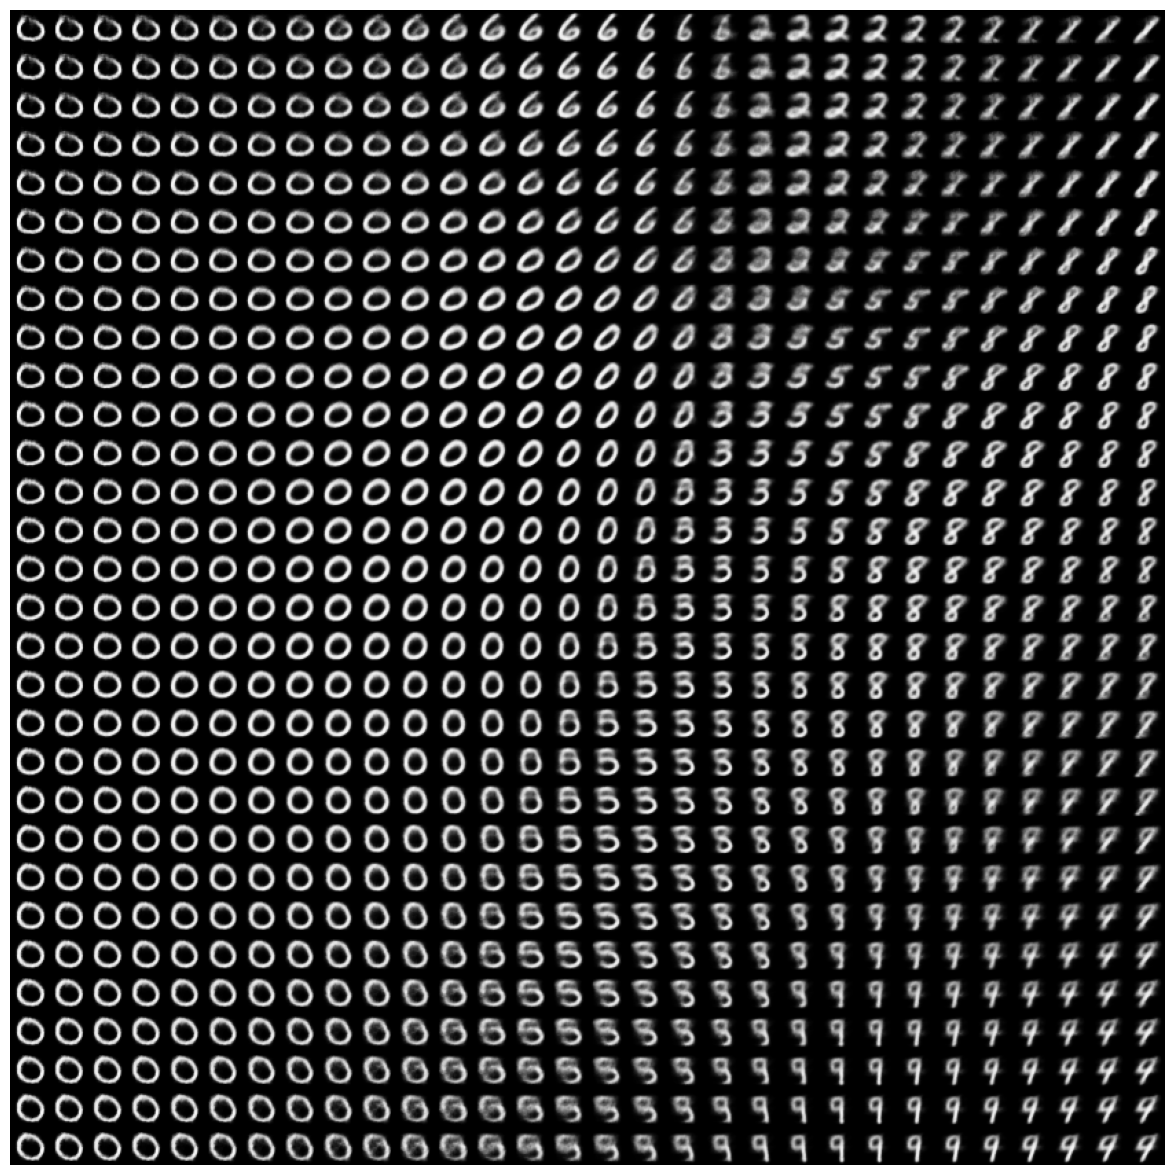

In [8]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")